# Tasca - Test d'hipòtesis

## Preprocessament del dataset

Utilitzarem aquest dataset de Kaggle que inclou els atlètes i resultats (medalles) durant 120 anys de jocs olímpics

https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

In [1]:
# Dataset de Kaggle: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

# Nota: l'afegit '&> /dev/null' evita que es mostrin en el notebook el resultat
# d'executar commanes de terminal com pip, wget, etc. I així el notebook queda més net. 

!pip install kaggle &> /dev/null

!wget -O kaggle.json https://www.dropbox.com/s/xm28qj0cdfopm6c/kaggle.json?dl=0 &> /dev/null
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json &> /dev/null

!kaggle datasets download "heesoo37/120-years-of-olympic-history-athletes-and-results/" &> /dev/null

!unzip 120-years-of-olympic-history-athletes-and-results.zip

Archive:  120-years-of-olympic-history-athletes-and-results.zip
  inflating: athlete_events.csv      
  inflating: noc_regions.csv         


El fitxer athlete_events.csv conté 271116 files i 15 columnes. Cada fila correspon a un atleta individual competing en un event olímpic. Les columnes són::

- ID - Unique number for each athlete
- Name - Athlete's name
- Sex - M or F
- Age - Integer
- Height - In centimeters
- Weight - In kilograms
- Team - Team name
- NOC - National Olympic Committee 3-letter code
- Games - Year and season
- Year - Integer
- Season - Summer or Winter
- City - Host city
- Sport - Sport
- Event - Event
- Medal - Gold, Silver, Bronze, or NA

In [2]:
# Instal·lem la darrera versió de Scipy, perquè Google Colab porta la 1.4 per defecte
!pip install --upgrade scipy

     |████████████████████████████████| 27.4MB 150kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [48]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [49]:
df = pd.read_csv('athlete_events.csv', index_col='ID')

In [50]:
df.sample(7)

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
44330,Gwon Jung-Hyeon,M,26.0,170.0,65.0,South Korea,KOR,1968 Summer,1968,Summer,Mexico City,Cycling,Cycling Men's Sprint,NaN
116813,Hiroshi Suzuki,M,36.0,173.0,81.0,Japan,JPN,2010 Winter,2010,Winter,Vancouver,Bobsleigh,Bobsleigh Men's Four,NaN
54622,Jaroslav Jebek,M,33.0,171.0,81.0,Slovakia,SVK,2004 Summer,2004,Summer,Athina,Cycling,Cycling Men's Keirin,NaN
125115,Lia Vanea,F,26.0,177.0,67.0,Romania,ROU,1964 Summer,1964,Summer,Tokyo,Volleyball,Volleyball Women's Volleyball,NaN
70349,Pentti Tapio Aleksi Linnosvuo (Lindroos-),M,27.0,182.0,79.0,Finland,FIN,1960 Summer,1960,Summer,Roma,Shooting,"Shooting Men's Free Pistol, 50 metres",NaN
15932,Yelyzaveta Viktorivna Bryzhina,F,26.0,173.0,63.0,Ukraine,UKR,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Women's 4 x 100 metres Relay,NaN
101374,Nathan James Robertson,M,27.0,187.0,82.0,Great Britain,GBR,2004 Summer,2004,Summer,Athina,Badminton,Badminton Men's Doubles,NaN


In [51]:
# A partir de la columna Event creem una columna on indiquem categoria de l'esport
# en cas que existeixi (e.g. Atletisme --> 100meters, 5 mile, etc) i gènere de la competició (M=Homes, F=Dones, Mixed=Mixte)
# Si no hi ha categories, llavors posem '-' (e.g. Basketball --> -)

df['SportCategory'] = df.Event.replace("(.+\'s\s)|(?:(.+\s)(?:Mixed))","",regex=True)
df['SportCategory'] = df.apply(lambda row: '-' if (row.SportCategory == row.Sport) else row.SportCategory, axis=1)

df['SportGenre'] = df.apply(lambda row: 'Mixed' if ('Mixed' in row.Event) else row.Sex, axis=1)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 1 to 135571
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Name           271116 non-null  object 
 1   Sex            271116 non-null  object 
 2   Age            261642 non-null  float64
 3   Height         210945 non-null  float64
 4   Weight         208241 non-null  float64
 5   Team           271116 non-null  object 
 6   NOC            271116 non-null  object 
 7   Games          271116 non-null  object 
 8   Year           271116 non-null  int64  
 9   Season         271116 non-null  object 
 10  City           271116 non-null  object 
 11  Sport          271116 non-null  object 
 12  Event          271116 non-null  object 
 13  Medal          39783 non-null   object 
 14  SportCategory  271116 non-null  object 
 15  SportGenre     271116 non-null  object 
dtypes: float64(3), int64(1), object(12)
memory usage: 35.2+ MB


In [53]:
# Per a les medalles, substituim NaN per "None" i convertim a tipus categòric 
# ordinal (None < Bronze < Silver < Gold)

# Nota: 85% de les files tenen Medal=NaN. Podria ser que algun d'aquests NaN 
# estigués indicant que no es té la informació de si va guanyar medalla o no, 
# però entenem que aquí majoritariament els NaN aquí indiquen que l'atleta no va guanyar cap medalla

df.Medal.fillna('None',inplace=True)
medal_type = pd.CategoricalDtype(categories=["None", "Bronze", "Silver", "Gold"], ordered=True)
df.Medal = df.Medal.astype(medal_type)

# Sex i Season també les convertim a categòrica
df.Sex = df.Sex.astype('category')
df.Season = df.Season.astype('category')

# Convertim Age a enter Int64 (en majuscules, per permetre valors NaN)
df.Age = df.Age.astype('Int64')

In [54]:
# Reordenem les columnes i guardem en un csv
df = df[['Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Event','Sport', 'SportCategory',
       'SportGenre','Medal']]

df.to_csv('120-years-olympic-results_clean.csv')

In [55]:
df.sample(7)

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Event,Sport,SportCategory,SportGenre,Medal
ID,,,,,,,,,,,,,,,,
111496,Curt Josef Sjberg,M,31,NaN,NaN,Sweden,SWE,1928 Summer,1928,Summer,Amsterdam,Diving Men's Springboard,Diving,Springboard,M,None
39421,"Maksim ""Max"" Geller",M,21,172.0,71.0,Israel,ISR,1992 Summer,1992,Summer,Barcelona,"Wrestling Men's Lightweight, Freestyle",Wrestling,"Lightweight, Freestyle",M,None
116735,Kellie D. Suttle (-Dolrenry),F,31,170.0,59.0,United States,USA,2004 Summer,2004,Summer,Athina,Athletics Women's Pole Vault,Athletics,Pole Vault,F,None
105484,Eriko Sanmiya,F,27,163.0,60.0,Japan,JPN,2002 Winter,2002,Winter,Salt Lake City,Speed Skating Women's 500 metres,Speed Skating,500 metres,F,None
72160,Luiz Felipe Marques Fonteles,M,32,196.0,89.0,Brazil,BRA,2016 Summer,2016,Summer,Rio de Janeiro,Volleyball Men's Volleyball,Volleyball,-,M,Gold
115766,Erwin Stricker,M,25,172.0,74.0,Italy,ITA,1976 Winter,1976,Winter,Innsbruck,Alpine Skiing Men's Downhill,Alpine Skiing,Downhill,M,None
73690,Maria Maioru,F,20,NaN,NaN,Romania,ROU,1980 Winter,1980,Winter,Lake Placid,Luge Women's Singles,Luge,Singles,F,None


## Exercici 1
Agafa un conjunt de dades de tema esportiu que t'agradi i selecciona un atribut del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%. 



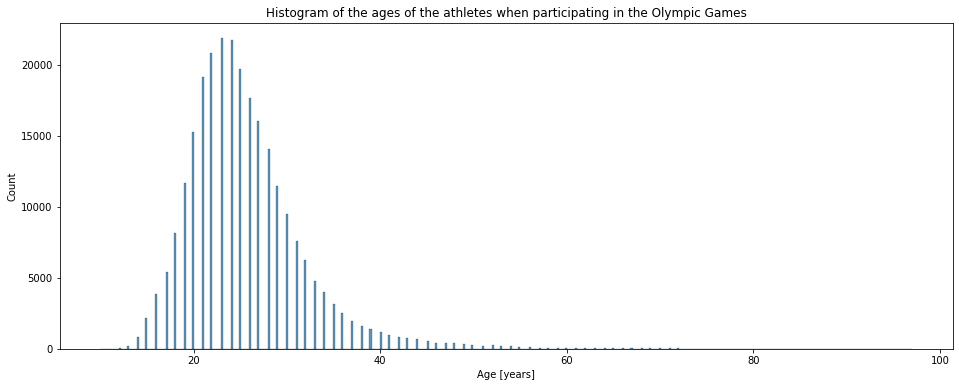

In [56]:
# Histograma de les edats dels atletes als jocs olimpics
plt.figure(figsize=(16, 6))
sns.histplot(data=df, x='Age')

plt.title('Histogram of the ages of the athletes when participating in the Olympic Games');
plt.xlabel('Age [years]');

In [57]:
print(f'The sample mean of Age is: {df.Age.mean():.3f} years')

The sample mean of Age is: 25.557 years


Hipotesis:
- $H_0: \mu_M = 25$  L'edat mitjana dels atletes olímpics és de 25 anys
- $H_1: \mu_M \neq 25$ L'edat mitjana dels atletes olímpics no és de 25 anys

In [58]:
# Utilitzsem 1 sample t-test

ALPHA = 0.05

stat, p = ttest_1samp(df.Age.dropna(), popmean=25)

print(f't-statistic = {stat:.3f}\np-value = {p:.3f}')
print('We can not reject H0') if p > ALPHA else print('We can reject H0')

t-statistic = 44.554
p-value = 0.000
We can reject H0


Conclusió:

Rebutjem la hipòtesis nul·la. Disposem de prou evidència per rebutjar, amb un nivell de significancia del 5%, que la mitjana d'edat dels atletes als jocs olimpics sigui de 25 anys.

## Exercici 2
Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona dos atributs del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.

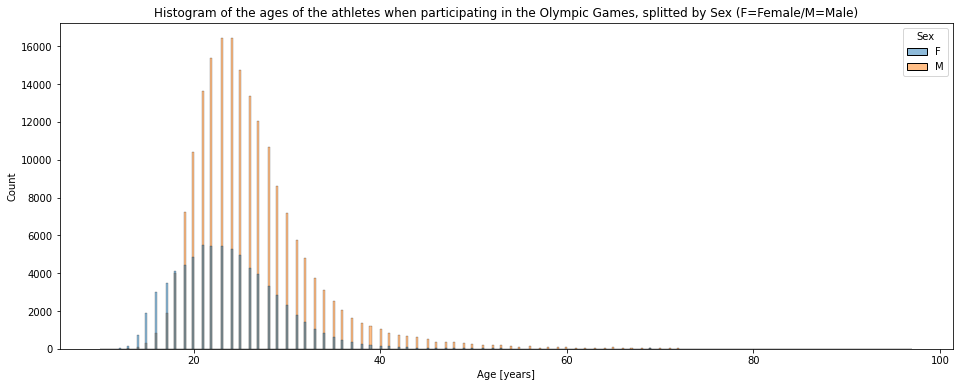

In [59]:
# Histograma de la distribució d'edats dels atletes segons el gènere 
plt.figure(figsize=(16, 6))
sns.histplot(data=df, x='Age', hue='Sex')

plt.title('Histogram of the ages of the athletes when participating in the Olympic Games, splitted by Sex (F=Female/M=Male)');
plt.xlabel('Age [years]');

Hipotesis:
- $H_0: \mu_M = \mu_F$  L'edat mitjana dels atletes olímpics (homes) **és igual** a la de les atletes olímpiques (dones)
- $H_1: \mu_M \neq \mu_F$ L'edat mitjana dels atletes olímpics (homes) **és diferent** a la de les atletes olímpiques (dones) 

In [60]:
# Utilitzsem la prova 2-tailed Welchs' t-test (equivalent a Student's t-test però
# quan no podem assegurar que dues poblacions tinguin mateixa variança)

ALPHA = 0.05

age_males = df.loc[df.Sex=='M','Age'].dropna()
age_females = df.loc[df.Sex=='F','Age'].dropna()

stat, p = ttest_ind(age_males,age_females, alternative='two-sided', equal_var=False)

print(f't-statistic = {stat:.3f}\np-value = {p:.3f}')
print('We can not reject H0') if p > ALPHA else print('We can reject H0')

t-statistic = 97.815
p-value = 0.000
We can reject H0


Conclusió:

Rebutjem la hipòtesis nul·la. Disposem de prou evidència per afirmar, amb un nivell de significancia del 5%, que hi ha una diferència significativa entre l'edat mitjana dels atletes homes i les atletes dones que participen als jocs olímpics.

## Exercici 3
Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona tres atributs del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.

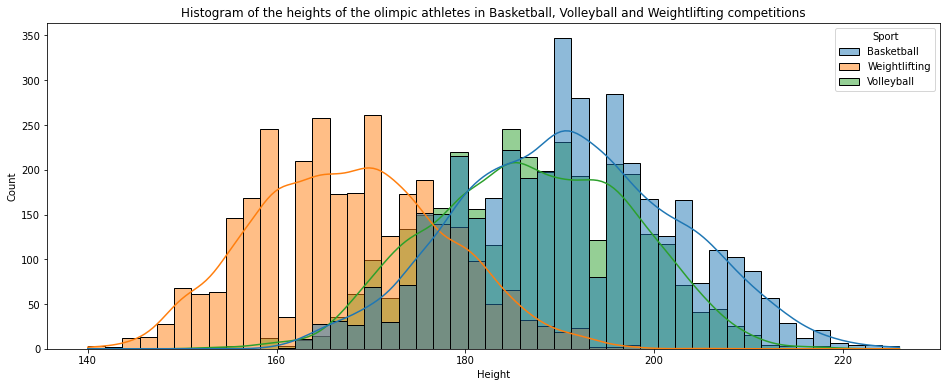

In [61]:
# Histograma de la distribució d'alçades dels atletes olimpics en Basket, Volley i Halterofilia

plt.figure(figsize=(16, 6))
sns.histplot(data=df[df.Sport.str.match('Basketball|Volleyball|Weightlifting')], x='Height', hue='Sport', kde=True)

plt.title('Histogram of the heights of the olimpic athletes in Basketball, Volleyball and Weightlifting competitions');


Hipotesis:
- $H_0: \mu_B = \mu_V = \mu_W$  Les alçades mitjanes dels atlètes olímpics en disciplines de Basketball, Volleyball i Weightlifting **són iguals**
- $H_1$: Les tres mitjanes **no són iguals**

In [62]:
# Utilitzem el test ANOVA per 3 grups

ALPHA = 0.05

height_basketball = df.loc[df.Sport=='Basketball','Height'].dropna()
height_volleyball = df.loc[df.Sport=='Volleyball','Height'].dropna()
height_weightlifting = df.loc[df.Sport=='Weightlifting','Height'].dropna()

stat, p = f_oneway(height_basketball,  height_volleyball, height_weightlifting)

print(f'F-statistic = {stat:.3f}\np-value = {p:.3f}')
print('We can not reject H0') if p > ALPHA else print('We can reject H0')

F-statistic = 4295.366
p-value = 0.000
We can reject H0


Conclusió 1:

Rebutjem la hipòtesis nul·la. Disposem de prou evidència per afirmar, amb un nivell de significancia del 5%, que l'alçada mitjana per als grups d'atletes olimpics competint en Basket, Volley i Halterofilia no és la mateixa.


El resultat del test ANOVA ens diu que no podem afirmar que les 3 mitjanes siguin iguals, però no ens permet rebutjar que siguin iguals dos a dos. Per això, hem d'aplicar el test de TUKEY.

In [63]:
# Comparació de multiples grups per parells (Tukey HSD)

ALPHA = 0.05

foo = df.loc[df.Sport.str.match('Basketball|Volleyball|Weightlifting'), ['Height','Sport']].dropna()

m_comp = pairwise_tukeyhsd(endog=foo['Height'], groups=foo['Sport'], alpha=ALPHA)

print(m_comp)


      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1       group2    meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
Basketball    Volleyball  -3.8751 0.001  -4.4702  -3.2799   True
Basketball Weightlifting -23.0451 0.001 -23.6548 -22.4353   True
Volleyball Weightlifting   -19.17 0.001 -19.8036 -18.5365   True
----------------------------------------------------------------


Conclusió 2:

Disposem de prou evidència per afirmar, amb un nivell de significancia del 5%, que cap dels tres grups d'atletes (Basket, Volley, Halterofilia) té la mateixa alçada mitjana que un dels altres grups.